# BP神经网络分类心电信号

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as Fun

## 读取数据并处理

In [2]:
data_filepath = "../data/numpy_data/"

X_train = np.load(data_filepath + 'X_train.npy')
y_train = np.load(data_filepath + 'y_train.npy', allow_pickle=True)
X_test = np.load(data_filepath + 'X_test.npy')
y_test = np.load(data_filepath + 'y_test.npy', allow_pickle=True)

# reshape y_train, y_test
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [3]:
def shuffle_train_test(X_train, y_train, X_test, y_test):
    shuffled_indices_x = np.random.permutation(len(y_train))
    shuffled_indices_y = np.random.permutation(len(y_test))

    return X_train[shuffled_indices_x], y_train[shuffled_indices_x], X_test[shuffled_indices_y], y_test[shuffled_indices_y]

In [4]:
# 打乱数据
X_train, y_train, X_test, y_test = shuffle_train_test(X_train, y_train, X_test, y_test)

### 调整数据格式

In [5]:
num2class = np.array(['NORM', 'MI', 'STTC', 'CD', 'HYP'])

for index in range(len(y_train)):
    y_train[index] = np.where(num2class == y_train[index][0][0])[0]

In [6]:
for index in range(len(y_test)):
    y_test[index] = np.where(num2class == y_test[index][0][0])[0]

In [7]:
# y_train = y_train.reshape(1, -1)[0].astype('uint8')
# y_test = y_test.reshape(1, -1)[0].astype('uint8')

In [8]:
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')

In [9]:
y_test

array([[3],
       [4],
       [2],
       ...,
       [4],
       [0],
       [4]], dtype=uint8)

In [10]:
y_train

array([[3],
       [0],
       [0],
       ...,
       [2],
       [3],
       [0]], dtype=uint8)

### label转换为one-hot

In [11]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
y_train_oneHot = encoder.fit_transform(y_train)
y_train_oneHot

array([[0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0]])

In [12]:
y_test_oneHot = encoder.fit_transform(y_test)
y_test_oneHot

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])

## PCA降维

In [13]:
from sklearn.decomposition import PCA

X_train_flatten = X_train.reshape(len(X_train), 6000)
pca_train = PCA(n_components=180)
pca_train.fit(X_train_flatten)

X_train_pca = pca_train.fit_transform(X_train_flatten)

In [14]:
pca_train.explained_variance_ratio_.sum()

0.9796370766454483

In [15]:
X_train_pca.shape

(16966, 180)

In [16]:
X_test_flatten = X_test.reshape(len(X_test), 6000)
pca_test = PCA(n_components=180)
pca_test = PCA(X_test_flatten)

X_test_pca = pca_train.fit_transform(X_test_flatten)

In [17]:
X_test_pca = pca_train.fit_transform(X_test_flatten)

In [18]:
X_test_pca.shape

(1901, 180)

### 归一化处理

In [19]:
# X_train_normalization = (X_train_pca - np.mean(X_train_pca, axis=1)) / np.std(X_train_pca, axis=1)
# X_test_normalization = (X_test_pca - np.mean(X_test_pca, axis=1)) / np.std(X_test_pca, axis=1)

In [20]:
# X_train_normalization[0].shape

In [21]:
# %matplotlib auto
# ecgPca = pca_train.inverse_transform(X_train_normalization[0]).reshape(500, 12)
# plt.figure()
# for index in range(12):
#     plt.subplot(6, 2, index+1)
#     plt.plot(ecgPca[:,index])
# plt.show()

### 将`numpy`转换为`tensor`

In [22]:
X_train_tensor = torch.tensor(X_train_pca, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)

X_test_tensor = torch.tensor(X_test_pca, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

In [23]:
# 合并打包，方便后面使用mini-batch的方法
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_iter = torch.utils.data.DataLoader(dataset, 50 ,shuffle=True)

## BP神经网络模型

使用简单的三层BP神经网络实现心电的分类，这里容易得到的是神经网络输入层根据输入变量`X`维度，需要设置180个神经元， 输出层因为是5分类，需要5个输出层，中间的隐含层根据公式

$$
n_1 = \sqrt{m+n} + a
$$

设置隐含层神经元数在15-25之间

In [24]:
import torch
from torch import nn
import torch.nn.functional as Fun

device = torch.device("cuda:0" if torch.cuda.is_available() else
"cpu")
device

device(type='cuda', index=0)

In [25]:
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_features, n_hidden)
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, X_data):
        x = self.hidden(X_data)
        x_relu = Fun.tanh(x)
        x = self.out(x_relu)
        predict_y = Fun.softmax(x)
        return predict_y

In [26]:
hidden_layers = 20
net = Net(180, hidden_layers, 5)
net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()

In [27]:
train_ls, test_ls = [], []
epoches = 100
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
for epoch in range(epoches):
    if epoch/10 == 0:
        print("----epoches %d finished----" % epoch)
    for x, y in train_iter:
        x = x.to(device)
        y = y.to(device)
        out = net(x)
        # print(out)
        # print(y.reshape(1,-1)[0])
        l = loss(out, y.reshape(1,-1)[0].long())
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    train_ls.append(l)
    if test_ls is not None:
        
        test_ls.append(loss(net(X_test_tensor), y_test_tensor.reshape(1,-1)[0].long()))

----epoches 0 finished----


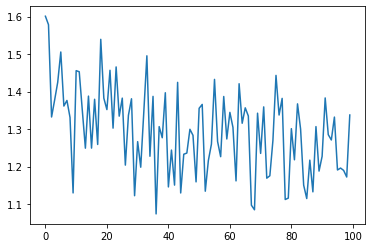

In [28]:
# 绘制训练误差
plt.plot(train_ls)
plt.show()

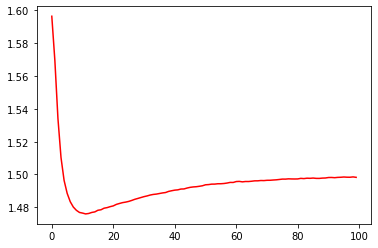

In [29]:
# 绘制测试误差
plt.plot(test_ls, c='r')
plt.show()

## 预测测试集验证性能

In [30]:
y_test_pred = net(X_test_tensor).detach_().cpu().numpy()
y_test_pred.shape

(1901, 5)

In [31]:
y_test_pred_label = y_test_pred.argmax(axis=1)

In [32]:
y_test_pred_label.shape

(1901,)

In [33]:
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score

confusion_matrix(y_test, y_test_pred_label)

array([[460,  30, 125, 160,  27],
       [ 85,  22,  25,  86,   4],
       [100,  28,  29, 104,   4],
       [126,  42,  40, 221,  21],
       [ 76,   6,  18,  50,  12]])

In [34]:
precision_score(y_test, y_test_pred_label, average='micro')

0.39137296159915835

In [35]:
recall_score(y_test, y_test_pred_label, average='micro')

0.39137296159915835

In [36]:
f1_score(y_test, y_test_pred_label, average='micro')

0.39137296159915835

## 尝试二分类

In [67]:
y_train_tensor_norm = (y_train_tensor == 0).float()
y_train_tensor_norm

tensor([[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [0.]])

In [123]:
y_test_tensor_norm = (y_test_tensor == 0).float()
y_test_tensor_norm

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]], device='cuda:0')

In [124]:
dataset_norm = torch.utils.data.TensorDataset(X_train_tensor.to(device), y_train_tensor_norm.to(device))
train_iter_norm = torch.utils.data.DataLoader(dataset_norm, 5 ,shuffle=True)

In [125]:
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_features, n_hidden)
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, X_data):
        x = self.hidden(X_data)
        x_relu = Fun.tanh(x)
        x = self.out(x_relu)
        predict_y = Fun.sigmoid(x)
        return predict_y

In [126]:
hidden_layers = 20
net = Net(180, hidden_layers, 1)
net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001)
loss = torch.nn.MSELoss()

In [127]:
train_ls_norm, test_ls_norm = [], []
epoches = 1000
X_test_tensor_norm = X_test_tensor.to(device)
y_test_tensor_norm = y_test_tensor.to(device)
for epoch in range(epoches):
    if epoch % 10 == 0:
        print("----epoches %d finished----" % epoch)
    for x, y in train_iter_norm:
        # x = x.to(device)
        # y = y.to(device)
        out = net(x)
        # print(out.shape)
        # print(y)
        l = loss(out, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    train_ls_norm.append(l)
    if test_ls_norm is not None:
        
        test_ls_norm.append(loss(net(X_test_tensor), y_test_tensor.reshape(1,-1)[0].long()))
print("----training success----")

----epoches 0 finished----


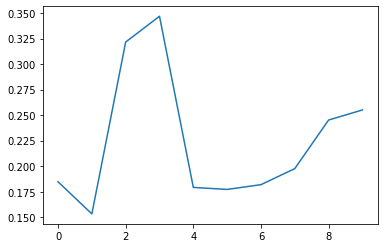

In [128]:
plt.plot(train_ls_norm)
plt.show()

[]

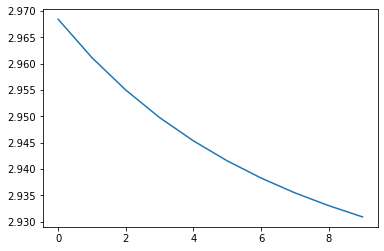

In [129]:
plt.plot(test_ls_norm)
plt.plot()

In [132]:
y_test_pred_norm = net(X_test_tensor_norm).detach_().cpu().numpy()
y_test_pred_norm = (y_test_pred_norm >= 0.5).astype('uint8')
y_test_pred_norm

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]], dtype=uint8)

In [133]:
y_test_tensor_norm.cpu().numpy().reshape(1, -1)[0].astype('uint8')

array([3, 4, 2, ..., 4, 0, 4], dtype=uint8)

In [134]:
precision_score(y_test_tensor_norm.cpu().numpy().reshape(1, -1)[0].astype('uint8'), y_test_pred_norm.reshape(1,-1)[0].astype('uint8'), average='macro')

0.1203700276675417

In [135]:
recall_score(y_test_tensor_norm.cpu().numpy().reshape(1, -1)[0].astype('uint8'), y_test_pred_norm.reshape(1,-1)[0].astype('uint8'), average='macro')

0.21628810855743524

In [136]:
f1_score(y_test_tensor_norm.cpu().numpy().reshape(1, -1)[0].astype('uint8'), y_test_pred_norm.reshape(1,-1)[0].astype('uint8'), average='macro')

0.13548660483073588